In [ ]:
# https://www.kaggle.com/code/debanga/cutmix-in-python
# https://medium.com/depurr/cutmix-augmentation-in-python-bf099a97afac

In [1]:
# import all packages
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [24]:
# set path to data
data_folder = f"/home/thenn/dssgxdfki2022-occrp/tests/test_data/test_data_image_augmentation/"

In [20]:
# set figure size
plt.rcParams["figure.figsize"] = [10, 10]

In [25]:
# read in all images
filenames = glob.glob(f"{data_folder}*.jpeg")

In [26]:
# read first 10 filenames
image_paths = filenames[:10]

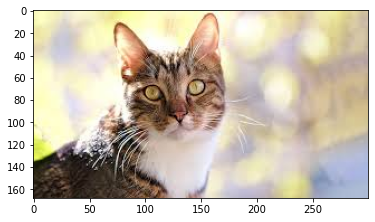

In [27]:
# display a sample image
plt.imshow(cv2.cvtColor(cv2.imread(image_paths[0]), cv2.COLOR_BGR2RGB))
plt.show();

In [156]:
# create batch of 4 images
image_batch = []
image_batch_labels = []

n_images = 4

In [157]:
# create label to mimique labels in real classifier
for i in range(n_images):
    image = cv2.cvtColor(cv2.imread(image_paths[i]), cv2.COLOR_BGR2RGB)
    image_batch.append(image)

    label_temp = list(np.floor(np.random.rand(1) * 2.99).astype(int))[0]
    if label_temp == 0:
        label = [1, 0, 0]
    elif label_temp == 1:
        label = [0, 1, 0]
    else:  # label_temp == 2
        label = [0, 0, 1]

    image_batch_labels.append(label)

In [163]:
# convert to np array and show labels
image_batch = np.array(image_batch)
# conver image_batch_labels to numpy array
image_batch_labels = np.array(image_batch_labels)

# print labels
print()
print(f"Image labels: {image_batch_labels}\n")


Image labels: [[1 0 0]
 [1 0 0]
 [0 0 1]
 [0 0 1]]



/tmp/ipykernel_21583/2862784247.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  image_batch = np.array(image_batch)


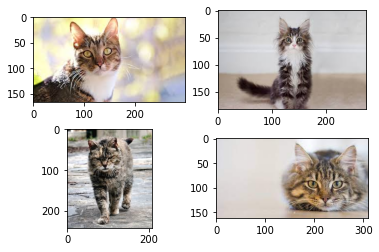

In [164]:
# show images
for i in range(2):
    for j in range(2):
        plt.subplot(2, 2, 2 * i + j + 1)
        plt.imshow(image_batch[2 * i + j])
plt.show()

In [195]:
len(image_batch[1])

183

In [165]:
# function to create bounding boxes
def rand_bbox(size, lamb):
    """Generate random bounding box
    Args:
        - size: [width, breadth] of the bounding box
        - lamb: (lambda) cut ratio parameter
    Returns:
        - Bounding box
    """
    W = size[0]
    H = size[1]
    cut_rat = np.sqrt(1.0 - lamb)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

/tmp/ipykernel_21583/4889342.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cut_w = np.int(W * cut_rat)
/tmp/ipykernel_21583/4889342.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more d

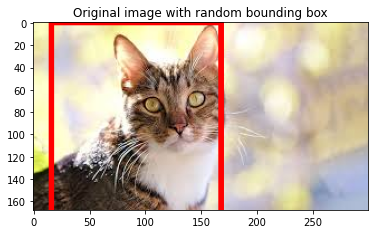

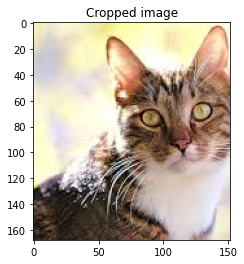

In [166]:
# read in image and create bounding box
# read an image
image = cv2.cvtColor(cv2.imread(image_paths[0]), cv2.COLOR_BGR2RGB)

# crop a random bounding box
lamb = 0.1
size = image.shape
bbox = rand_bbox(size, lamb)

# draw bounding box on the image
im = image.copy()
x1 = bbox[0]
y1 = bbox[1]
x2 = bbox[2]
y2 = bbox[3]
cv2.rectangle(im, (x1, y1), (x2, y2), (255, 0, 0), 3)
plt.imshow(im)
plt.title("Original image with random bounding box")
plt.show()

# show cropped image
plt.imshow(image[y1:y2, x1:x2])
plt.title("Cropped image")
plt.show()

In [191]:
# function to create cutmix image
def generate_cutmix_image(image_batch, image_batch_labels, beta):
    """Generate a CutMix augmented image from a batch
    Args:
        - image_batch: a batch of input images
        - image_batch_labels: labels corresponding to the image batch
        - beta: a parameter of Beta distribution.
    Returns:
        - CutMix image batch, updated labels
    """
    # generate mixed sample
    lam = np.random.beta(beta, beta)
    rand_index = np.random.permutation(len(image_batch))
    target_a = image_batch_labels
    target_b = image_batch_labels[rand_index]
    bbx1, bby1, bbx2, bby2 = rand_bbox(image_batch[0].shape, lam)
    image_batch_updated = image_batch.copy()
    print(image_batch_updated.shape)
    print("Dimension of the array is: ", len(np.shape(image_batch_updated)))
    image_batch_updated[:, bbx1:bbx2, bby1:bby2, :] = image_batch[rand_index, bbx1:bbx2, bby1:bby2, :]

    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (image_batch.shape[1] * image_batch.shape[2]))
    label = target_a * lam + target_b * (1.0 - lam)

    return image_batch_updated, label

In [192]:
# generate CutMix image
# Let's use the first image of the batch as the input image to be augmented
image_input = image_batch[0]
image_batch_updated, image_batch_labels_updated = generate_cutmix_image(image_batch, image_batch_labels, 1.0)

(4,)
Dimension of the array is:  1


/tmp/ipykernel_21583/4889342.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cut_w = np.int(W * cut_rat)
/tmp/ipykernel_21583/4889342.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more d

IndexError: too many indices for array: array is 1-dimensional, but 4 were indexed

Original Images


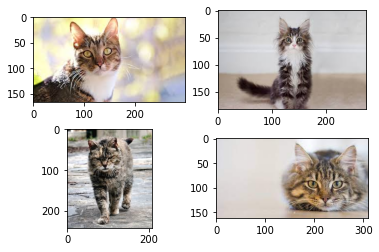

In [196]:
# show original images
print("Original Images")
for i in range(2):
    for j in range(2):
        plt.subplot(2, 2, 2 * i + j + 1)
        plt.imshow(image_batch[2 * i + j])
plt.show()

CutMix Images


NameError: name 'image_batch_updated' is not defined

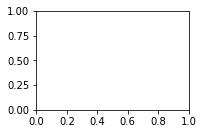

In [197]:
# show CutMix images
print("CutMix Images")
for i in range(2):
    for j in range(2):
        plt.subplot(2, 2, 2 * i + j + 1)
        plt.imshow(image_batch_updated[2 * i + j])
plt.show()